In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import os
import ntpath

In [2]:
# Read in JSON file
with open("/users/ngun7t/Documents/cellbox-jun-6/results/Pytorch_RP_fig2_rep_1ba9627bf3448ce6c49ecf163acbf684/config.json", "rb") as f:
    d = json.load(f)

# Read in the y_hat csv file of the last stage
y_hat = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/results/Pytorch_RP_fig2_rep_1ba9627bf3448ce6c49ecf163acbf684/seed_871/6_best.y_hat.loss.0.0426226481795311.csv")
y_hat = y_hat.drop("Unnamed: 0", axis=1)

# Read in the ground truth perturbation result
y_true = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv", header=None).to_numpy()

# Read in random_pos.csv
random_pos = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/results/Pytorch_RP_fig2_rep_1ba9627bf3448ce6c49ecf163acbf684/seed_871/random_pos.csv", header=None)[0].values

In [4]:
y_hat.shape

(27, 100)

In [7]:
y_true.shape[0]

89

In [24]:
trainset_ratio, validset_ratio = d["trainset_ratio"], d["validset_ratio"]
nvalid = int(y_true.shape[0] * trainset_ratio)
ntrain = int(nvalid * validset_ratio)

print(ntrain)
print(nvalid)
print(len(random_pos) - nvalid) 
print(y_hat.shape[0])

49
62
27
27


### Compare the content of y_hat to that of the ground truth

In [18]:
# Get those indices for test conditions
test_indices = random_pos[nvalid:]

# Get ground truth test expression
y_true_test = y_true[test_indices]

# Compare this with y_hat 
y_hat_test = y_hat.to_numpy()

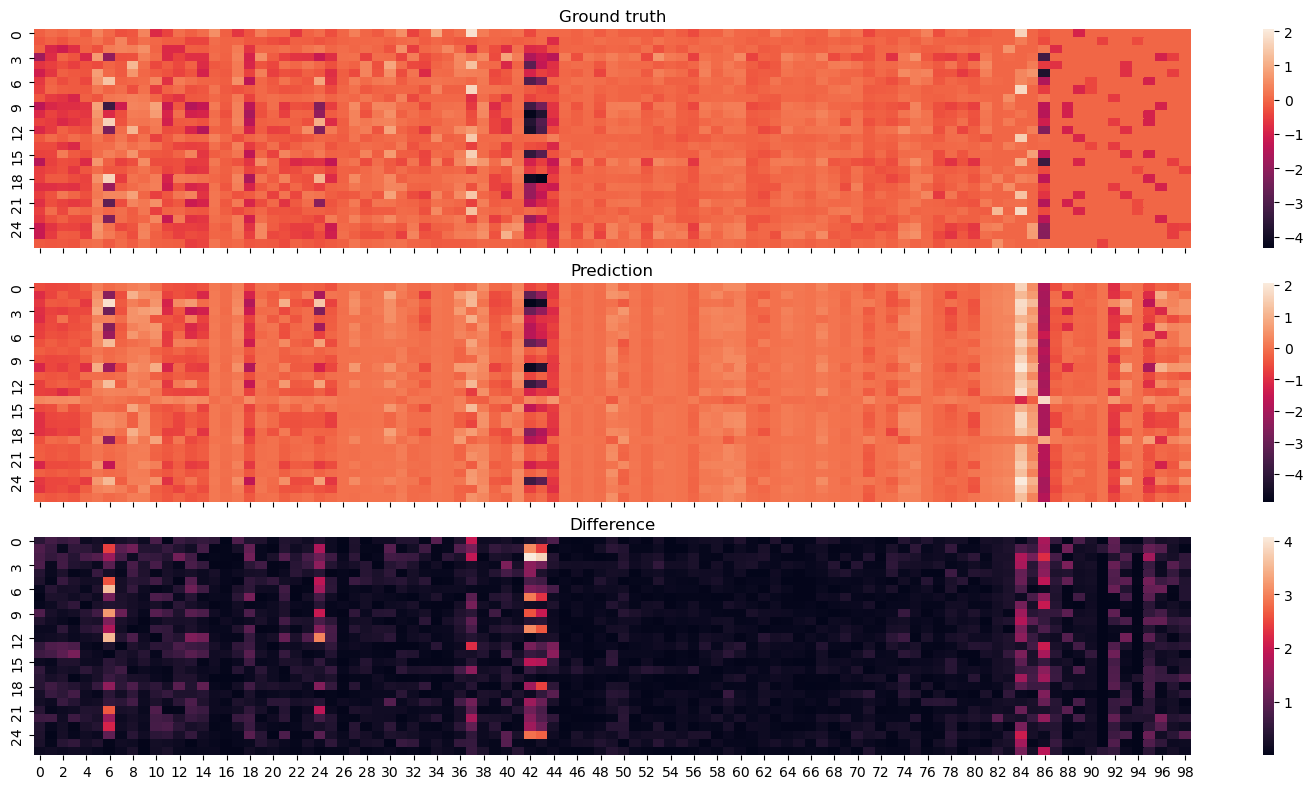

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 8), sharex=True)

max_val = max(np.amax(y_true_test), np.amax(y_hat_test))

sns.heatmap(y_true_test, ax=axes[0], vmax=max_val)
axes[0].set_title("Ground truth")
sns.heatmap(y_hat_test, ax=axes[1], vmax=max_val)
axes[1].set_title("Prediction")
sns.heatmap(np.abs(y_hat_test - y_true_test), ax=axes[2])
axes[2].set_title("Difference")
plt.tight_layout()
plt.show()

### Integrate information from the 500 trained models and see if we can replicate Figure 2 of the paper

Challenge: has to filter out oscillatory solutions

In [23]:
# Read in the ground truth perturbation result
y_true = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv", header=None).to_numpy()

base_dir = "/data/weirauchlab/team/ngun7t/cellbox_results/results/Pytorch_RP_fig2_rep_b0bf0e27d3c96f91d2e1c66b15d9b7c0"
with open(f"{base_dir}/config.json", "rb") as f:
    d = json.load(f)

experiments = glob.glob(os.path.join(base_dir, "seed_*"))
trainset_ratio, validset_ratio = d["trainset_ratio"], d["validset_ratio"]
nvalid = int(y_true.shape[0] * trainset_ratio)
ntrain = int(nvalid * validset_ratio)

expr_results = []

for experiment in experiments:

    # Create an empty numpy array
    expr_result = np.zeros(y_true.shape)

    # Read in random_pos.csv
    random_pos = pd.read_csv(f"{experiment}/random_pos.csv", header=None)[0].values
    test_indices = random_pos[nvalid:]

    # Read in the prediction
    expr_last_stage_dir = glob.glob(f"{experiment}/6_best.y_hat.loss*")
    if len(expr_last_stage_dir) != 0:
        y_hat = pd.read_csv(expr_last_stage_dir[0])
        y_hat = y_hat.drop("Unnamed: 0", axis=1)

        # Add the new result to the empty array
        expr_result[test_indices] = y_hat.to_numpy()
        # A very random cutoff
        if np.amax(expr_result) > 3 or np.amin(expr_result) < -6: continue
        else: expr_results.append(expr_result)
    else:
        print(f"Experiment {ntpath.basename(experiment)} did not finish")

result_arr = np.stack(expr_results, axis=0) # shape = (500, 89, 99)

Experiment seed_188 did not finish
Experiment seed_282 did not finish
Experiment seed_352 did not finish
Experiment seed_080 did not finish
Experiment seed_057 did not finish
Experiment seed_319 did not finish
Experiment seed_460 did not finish
Experiment seed_212 did not finish
Experiment seed_145 did not finish
Experiment seed_140 did not finish


In [24]:
counts = 0
for i in range(result_arr.shape[0]):
    slice = result_arr[i]
    #print(f"Max val: {np.amax(slice)}, min val: {np.amin(slice)}")
    if np.amax(slice) > 3 or np.amin(slice < -6):
        counts += 1
        print(f"Slice {i} has max val: {np.amax(slice)} at {np.unravel_index(np.argmax(slice), slice.shape)}, min val: {np.amin(slice)}")

In [25]:
nonzero_counts = np.count_nonzero(result_arr, axis=0)
sum_across_experiments = np.sum(result_arr, axis=0)
result_arr_average = sum_across_experiments / nonzero_counts

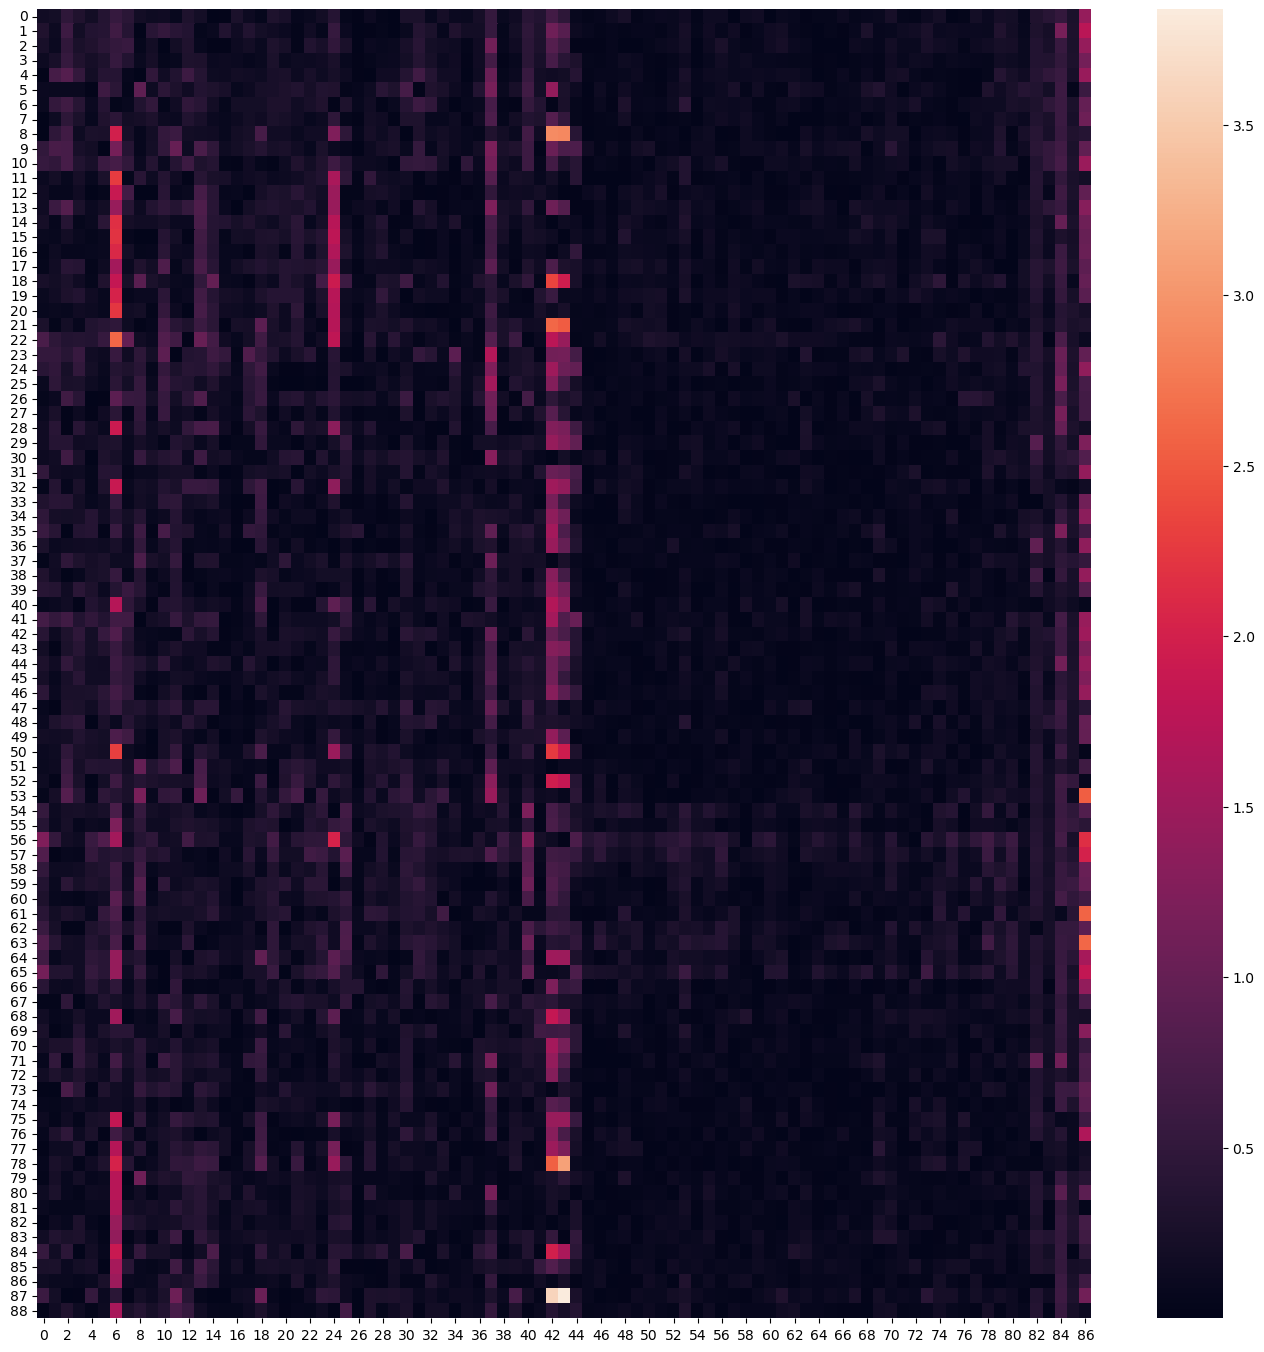

In [26]:
plt.figure(figsize=(17, 17))
sns.heatmap(np.abs(result_arr_average[:, :87] - y_true[:, :87]), vmax=np.amax(np.abs(result_arr_average[:, :87] - y_true[:, :87])))
plt.show()

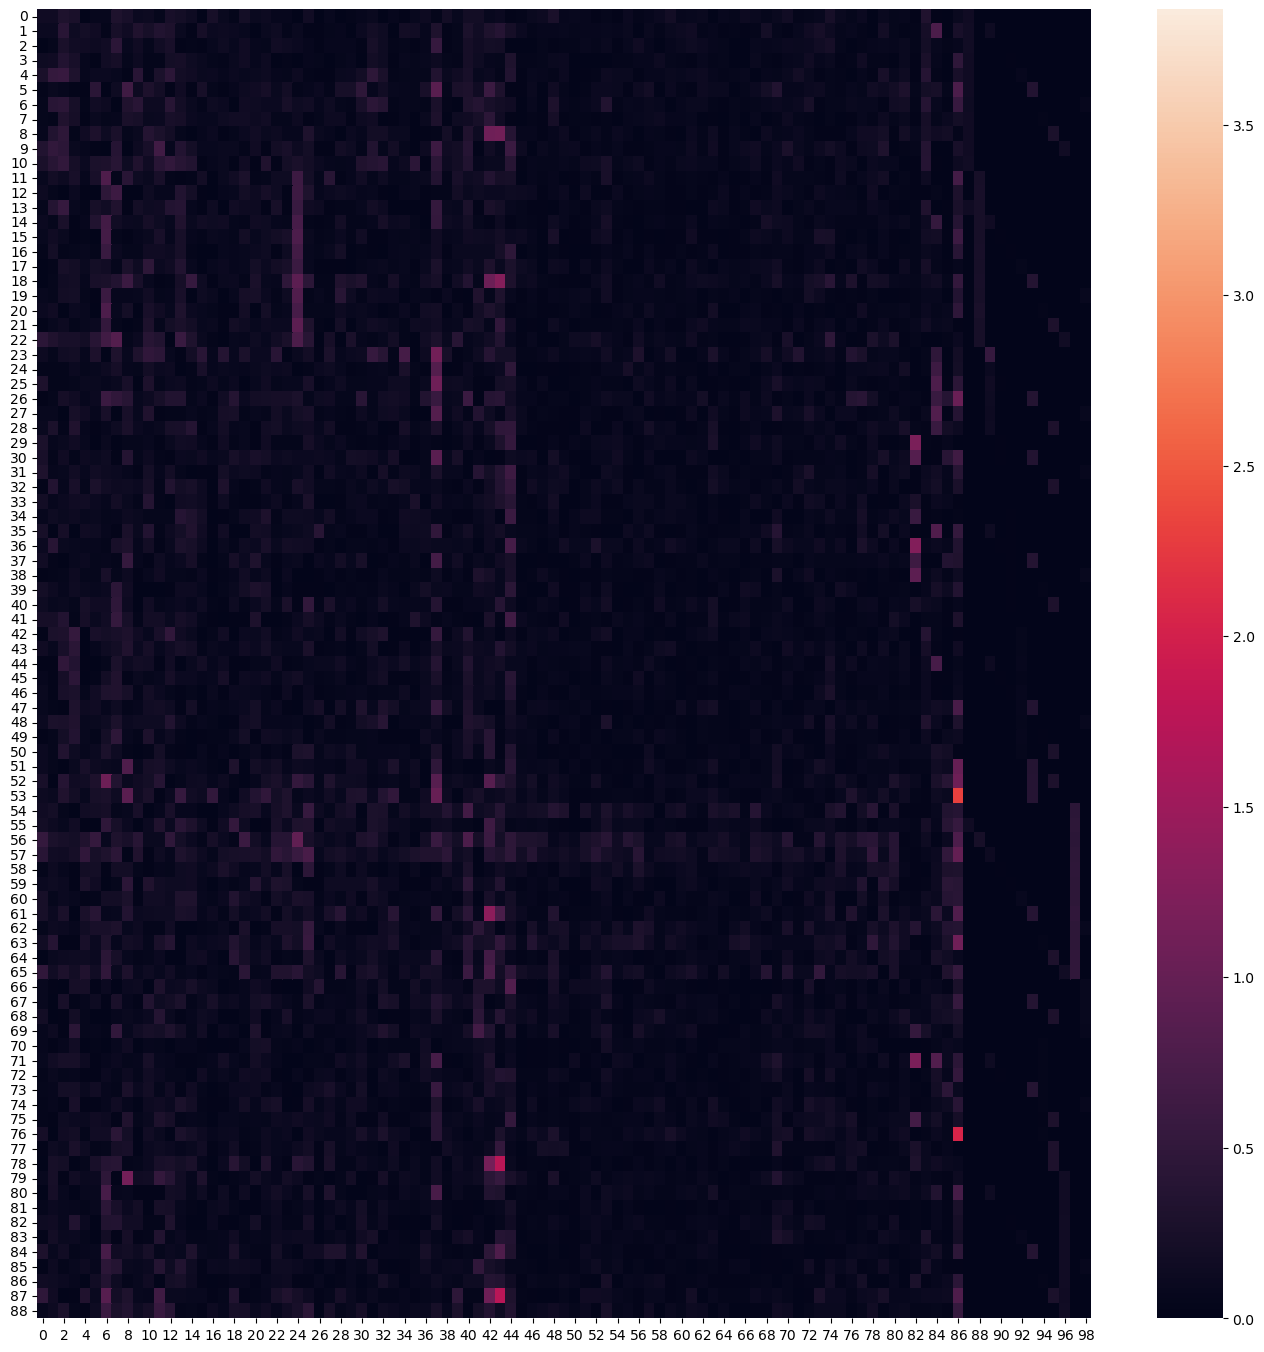

In [77]:
# Heatmap from the true average file
true_average = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/manuscript/Figure2/random_partition_average_testhat_929.csv", index_col=0).to_numpy()
plt.figure(figsize=(17, 17))
sns.heatmap(np.abs(true_average - y_true), vmax=np.amax(np.abs(result_arr_average - y_true)))
plt.show()

In [73]:
result_average_df = pd.DataFrame(result_arr_average)
result_average_df.to_csv(
    "/users/ngun7t/Documents/cellbox-jun-6/manuscript_rep/Figure2/random_partition_average_pytorch_490.csv",
)

### Do the same but for tensorflow code

In [2]:
# Read in the ground truth perturbation result
y_true = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv", header=None).to_numpy()

base_dir = "/data/weirauchlab/team/ngun7t/cellbox_results/results/Tensorflow_RP_fig2_rep_3db3abf024fd02760dedd90c6b3cbae9"
with open(f"{base_dir}/config.json", "rb") as f:
    d = json.load(f)

experiments = glob.glob(os.path.join(base_dir, "seed_*"))
trainset_ratio, validset_ratio = d["trainset_ratio"], d["validset_ratio"]
nvalid = int(y_true.shape[0] * trainset_ratio)
ntrain = int(nvalid * validset_ratio)

expr_results = []

for experiment in experiments:

    # Create an empty numpy array
    expr_result = np.zeros(y_true.shape)

    # Read in random_pos.csv
    random_pos = pd.read_csv(f"{experiment}/random_pos.csv", header=None)[0].values
    test_indices = random_pos[nvalid:]

    # Read in the prediction
    expr_last_stage_dir = glob.glob(f"{experiment}/6_best.y_hat.loss*")
    if len(expr_last_stage_dir) != 0:
        y_hat = pd.read_csv(expr_last_stage_dir[0])
        y_hat = y_hat.drop("Unnamed: 0", axis=1)

        # Add the new result to the empty array
        expr_result[test_indices] = y_hat.to_numpy()
        # A very random cutoff
        #if np.amax(expr_result) > 3 or np.amin(expr_result) < -6: continue
        #else: expr_results.append(expr_result)
        expr_results.append(expr_result)
    else:
        print(f"Experiment {ntpath.basename(experiment)} did not finish")

result_arr_tf = np.stack(expr_results, axis=0) # shape = (500, 89, 99)

In [19]:
#nonzero_counts_tf = np.count_nonzero(result_arr_tf, axis=0)[:, :87]
nonzero_counts_tf = np.repeat(np.expand_dims(np.sum(np.any(result_arr_tf != 0, axis=2), axis=0), axis=1), repeats=99, axis=-1)
sum_across_experiments_tf = np.sum(result_arr_tf, axis=0)
result_arr_average_tf = sum_across_experiments_tf / nonzero_counts_tf

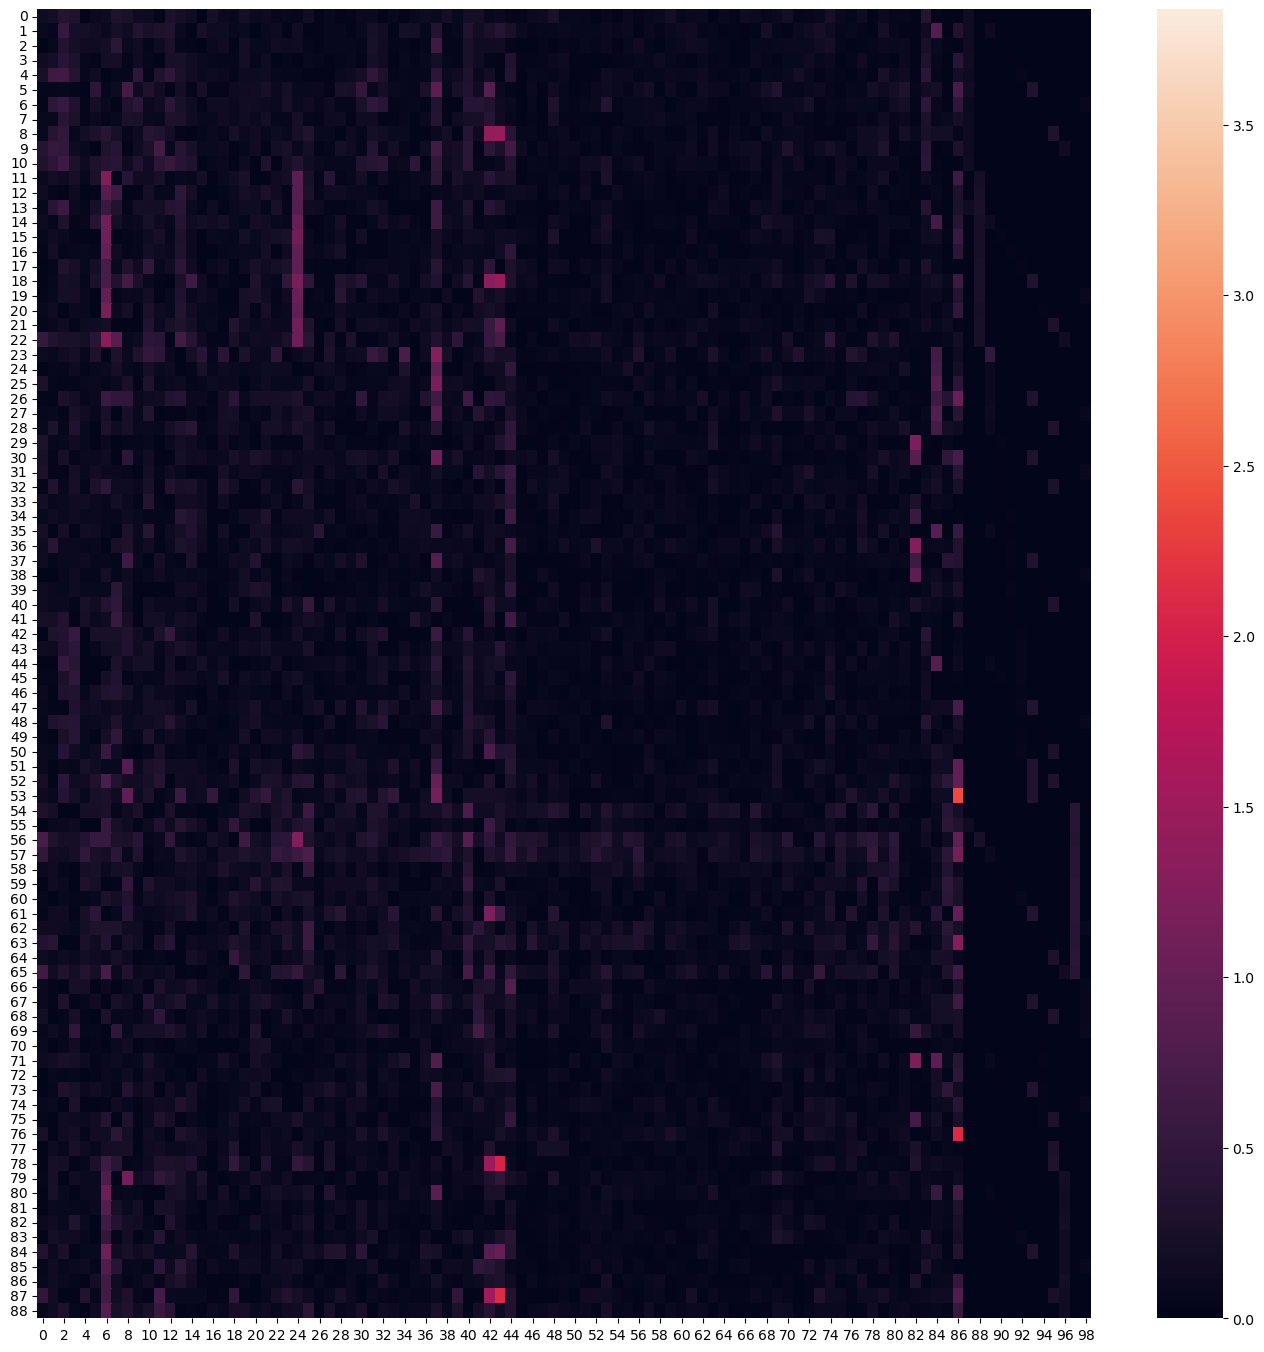

In [20]:
plt.figure(figsize=(17, 17))
sns.heatmap(np.abs(result_arr_average_tf - y_true), vmax=3.838)
plt.show()